# Image Processing

## Setup

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
print('Packages imported.')

Packages imported.


## *Background*: Filtering a signal with convolution
Let's start with a simple step signal (left) which we'll add some noise to (right).

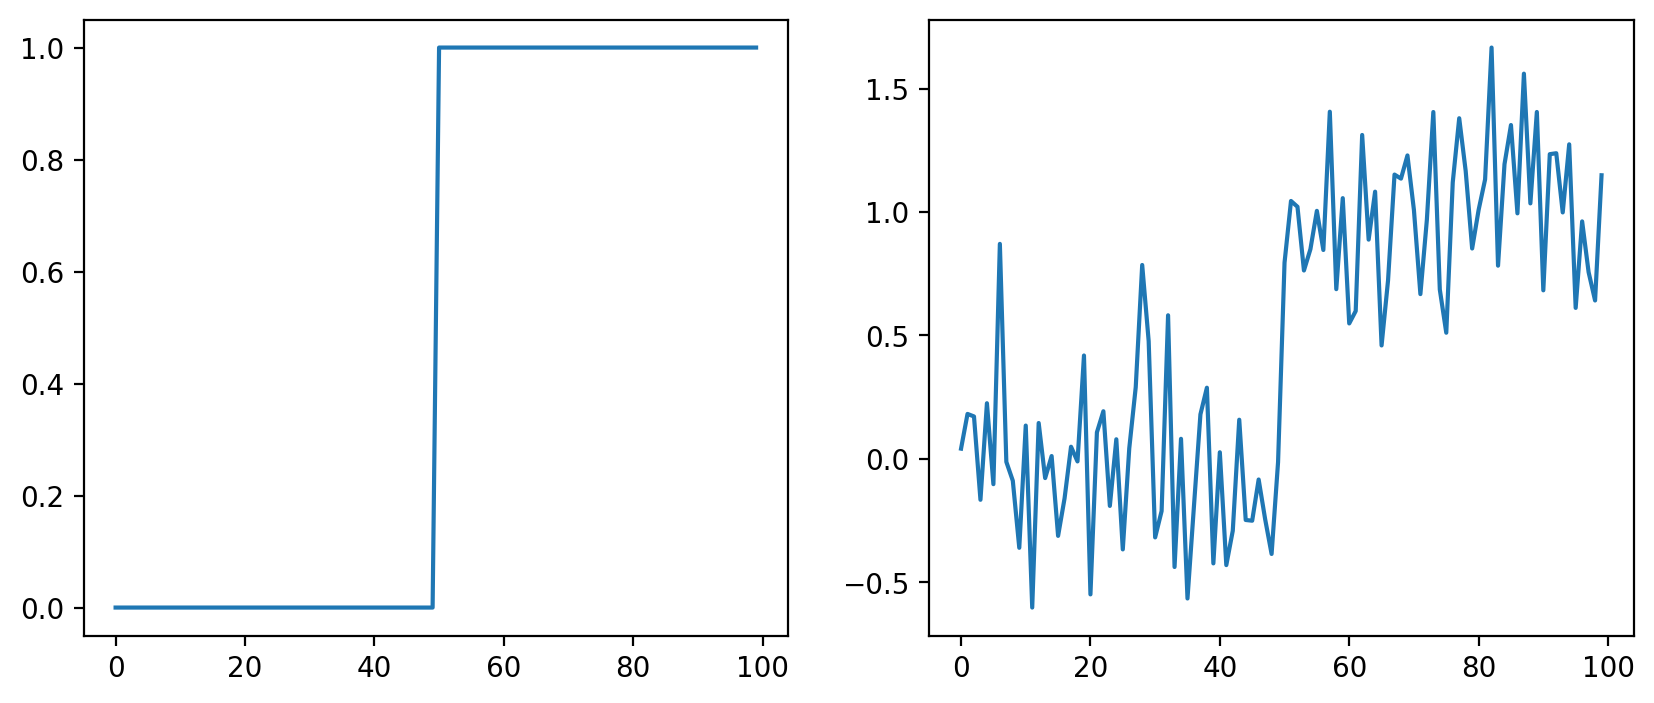

In [86]:
step_signal = np.zeros(100)
step_signal[50:] = 1
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(step_signal)

noisy_signal = (step_signal + 0.3*np.random.normal(0, 1, step_signal.shape))
ax[1].plot(noisy_signal)

plt.show()

If our goal is to cover something that looks more like the image on the left, we can **smooth** the signal. In the first line below, we'll take each point and average it by one datapoint to the left and one datapoint to the right, discarding the ends of the signal, where we can't do this operation.

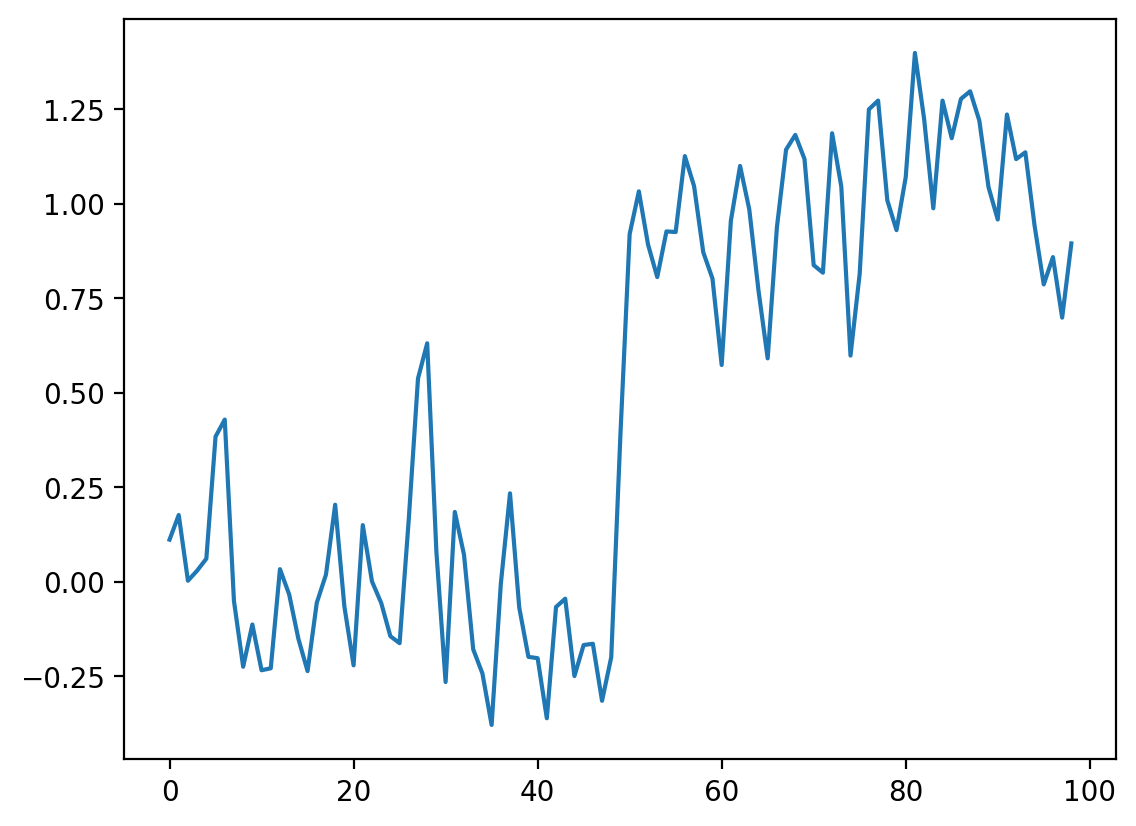

In [87]:
# Take the mean of neighboring datapoints
smooth_signal = (noisy_signal[:-1] + noisy_signal[1:]) / 2.0

plt.plot(smooth_signal)
plt.show()

Above, we're only averaging by one datapoint on each side. What if we average by 3 datapoints? Below, we'll do the following:
1. Create an output array called `smooth_signal3`, of the same length as noisy_signal.
2. At each element in `smooth_signal3` starting at point 1, and ending at point -2, place the average of the sum of: 1/3 of the element to the left of it in noisy_signal, 1/3 of the element at the same position, and 1/3 of the element to the right.
3. Discard the leftmost and rightmost elements.

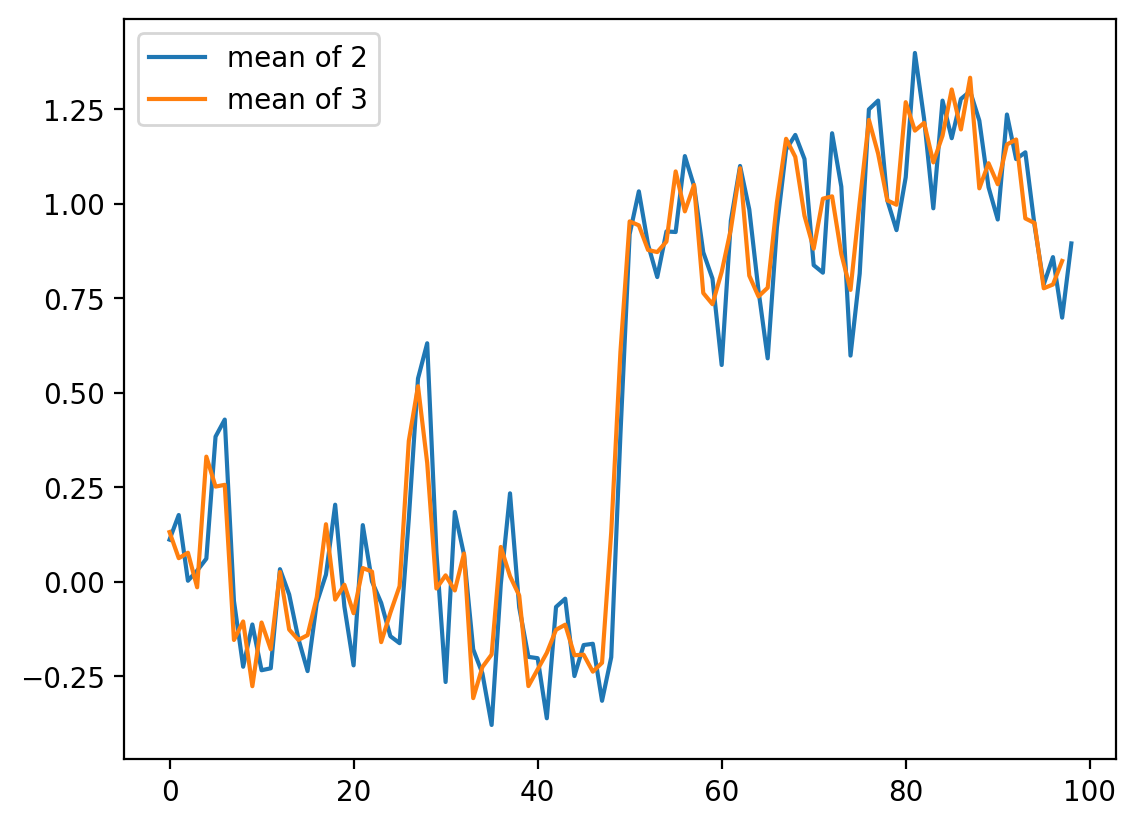

In [88]:
# Generate our signal
smooth_signal3 = (noisy_signal[:-2] + noisy_signal[1:-1] + noisy_signal[2:]) / 3

plt.plot(smooth_signal, label='mean of 2')
plt.plot(smooth_signal3, label='mean of 3')
plt.legend(loc='upper left')
plt.show()

If we want to continue this, the first line of our code is going to continue to get longer, and there isn't a straightforward way to make this flexible for how many points we want to average. Thankfully, there's a name for what we're doing: **convolving**. This same concept, nearest-neighbor averages, can be expressed as a **convolution with an averaging kernel**.

**Convolution** is the process of adding each element of the image to its local neighbors, weighted by the kernel. 

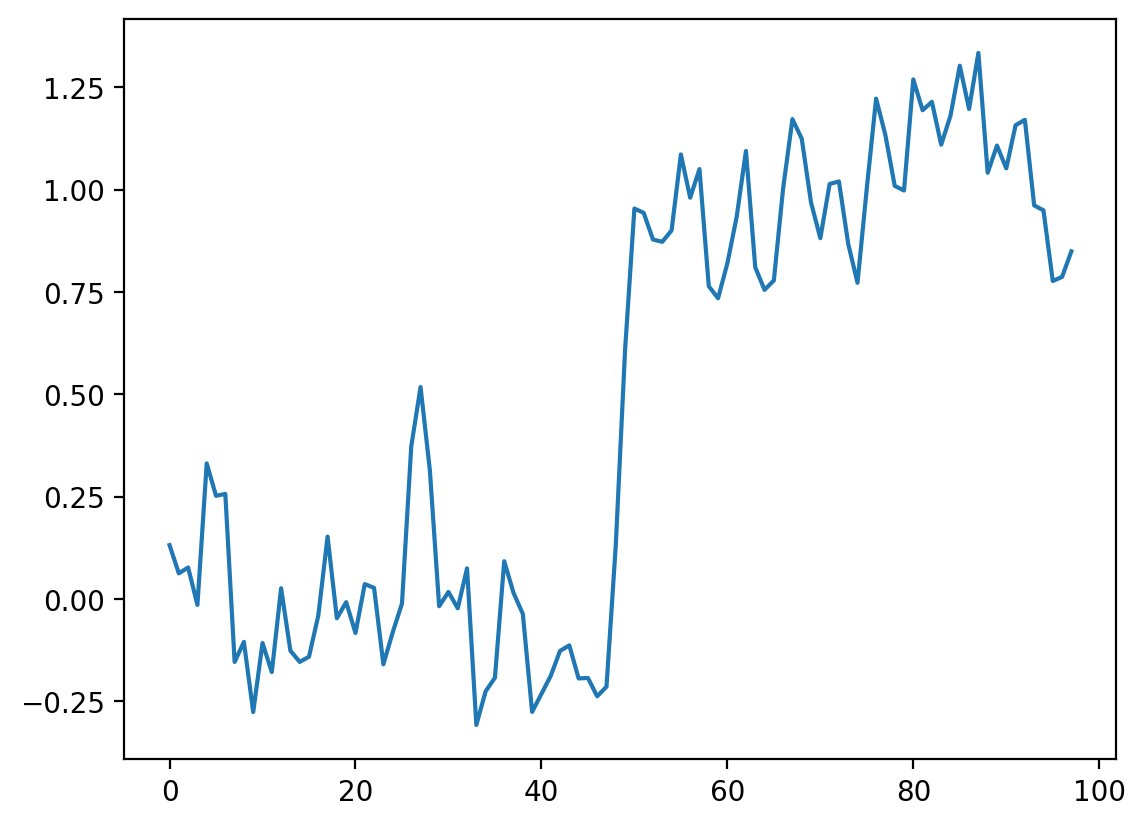

In [89]:
# Same as above, using a convolution kernel
# Neighboring pixels multiplied by 1/3 and summed

# Create the "kernel". For 3, this creates an array that looks like [0.333,0.333,0.333]
mean_kernel3 = np.full((3,), 1/3)

# Smooth the signal by convolving it
smooth_signal3p = np.convolve(noisy_signal, mean_kernel3, mode='valid')

plt.plot(smooth_signal3p)
plt.show()

In [93]:
# Check that they're equal!
print('smooth_signal3 and smooth_signal3p are equal:',
      np.allclose(smooth_signal3, smooth_signal3p))

print('smooth_signal2 and smooth_signal3p are equal:',
      np.allclose(smooth_signal[1:], smooth_signal3p))

smooth_signal3 and smooth_signal3p are equal: True
smooth_signal2 and smooth_signal3p are equal: False


> **Task**: What happens if we convolve with a kernel of size 10? Also, do these arrays have the same # of data points? If not, why?

##  Get familiar with using images in Python
Below, we'll import a package called `misc` because it contains some useful things for our exercise today --  images! The primary package we'll use today, not surprisingly, is `matplotlib.pyplot`. We'll use [`plt.imshow()`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.imshow.html) to show [our image](https://en.wikipedia.org/wiki/Cancer_cell#/media/File:Acute_lymphoblastic_leukaemia_smear.jpg).

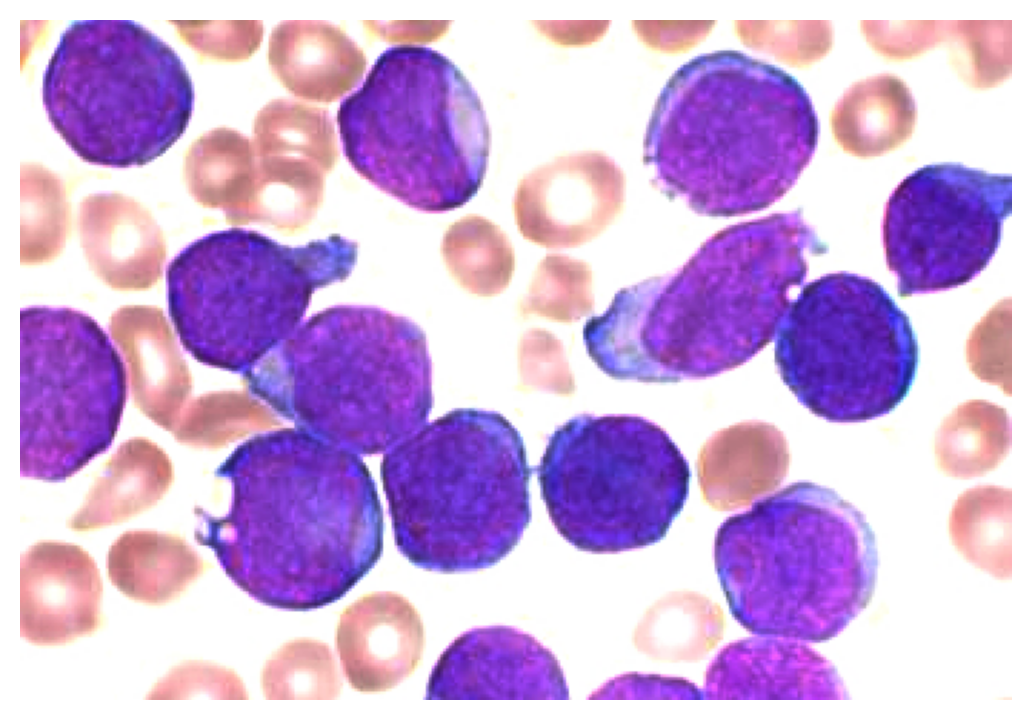

In [94]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # New module to read in images

cells = mpimg.imread('Images/leukaemia_smear.jpeg')
plt.axis('off')
plt.imshow(cells)
plt.show()

We can work with our `cells` object just like we would any other object. Let's check its shape. 

In [95]:
# Check cells shape
print(cells.shape)

(238, 347, 3)


If the first and second value are the size, what is the third value?
<div class="alert alert-success">

**Task**: Below, use only the first values in the third dimension to generate a different version of our image that is only based on the "R" luminance. Call this `cells_gray`.

</div>

In [24]:
cells_gray = np.mean(cells,axis=2)

By default, matplotlib uses the viridis color map to plot a sequence of values (you can see the luminance at each pixel by showing the colorbar with `plt.colorbar()`).
<div class="alert alert-success">
    
 **Task**. Change your image to a different colormamp using the `cmap` argument in `plt.imshow`. There are many [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) -- try some below!
    
</div>

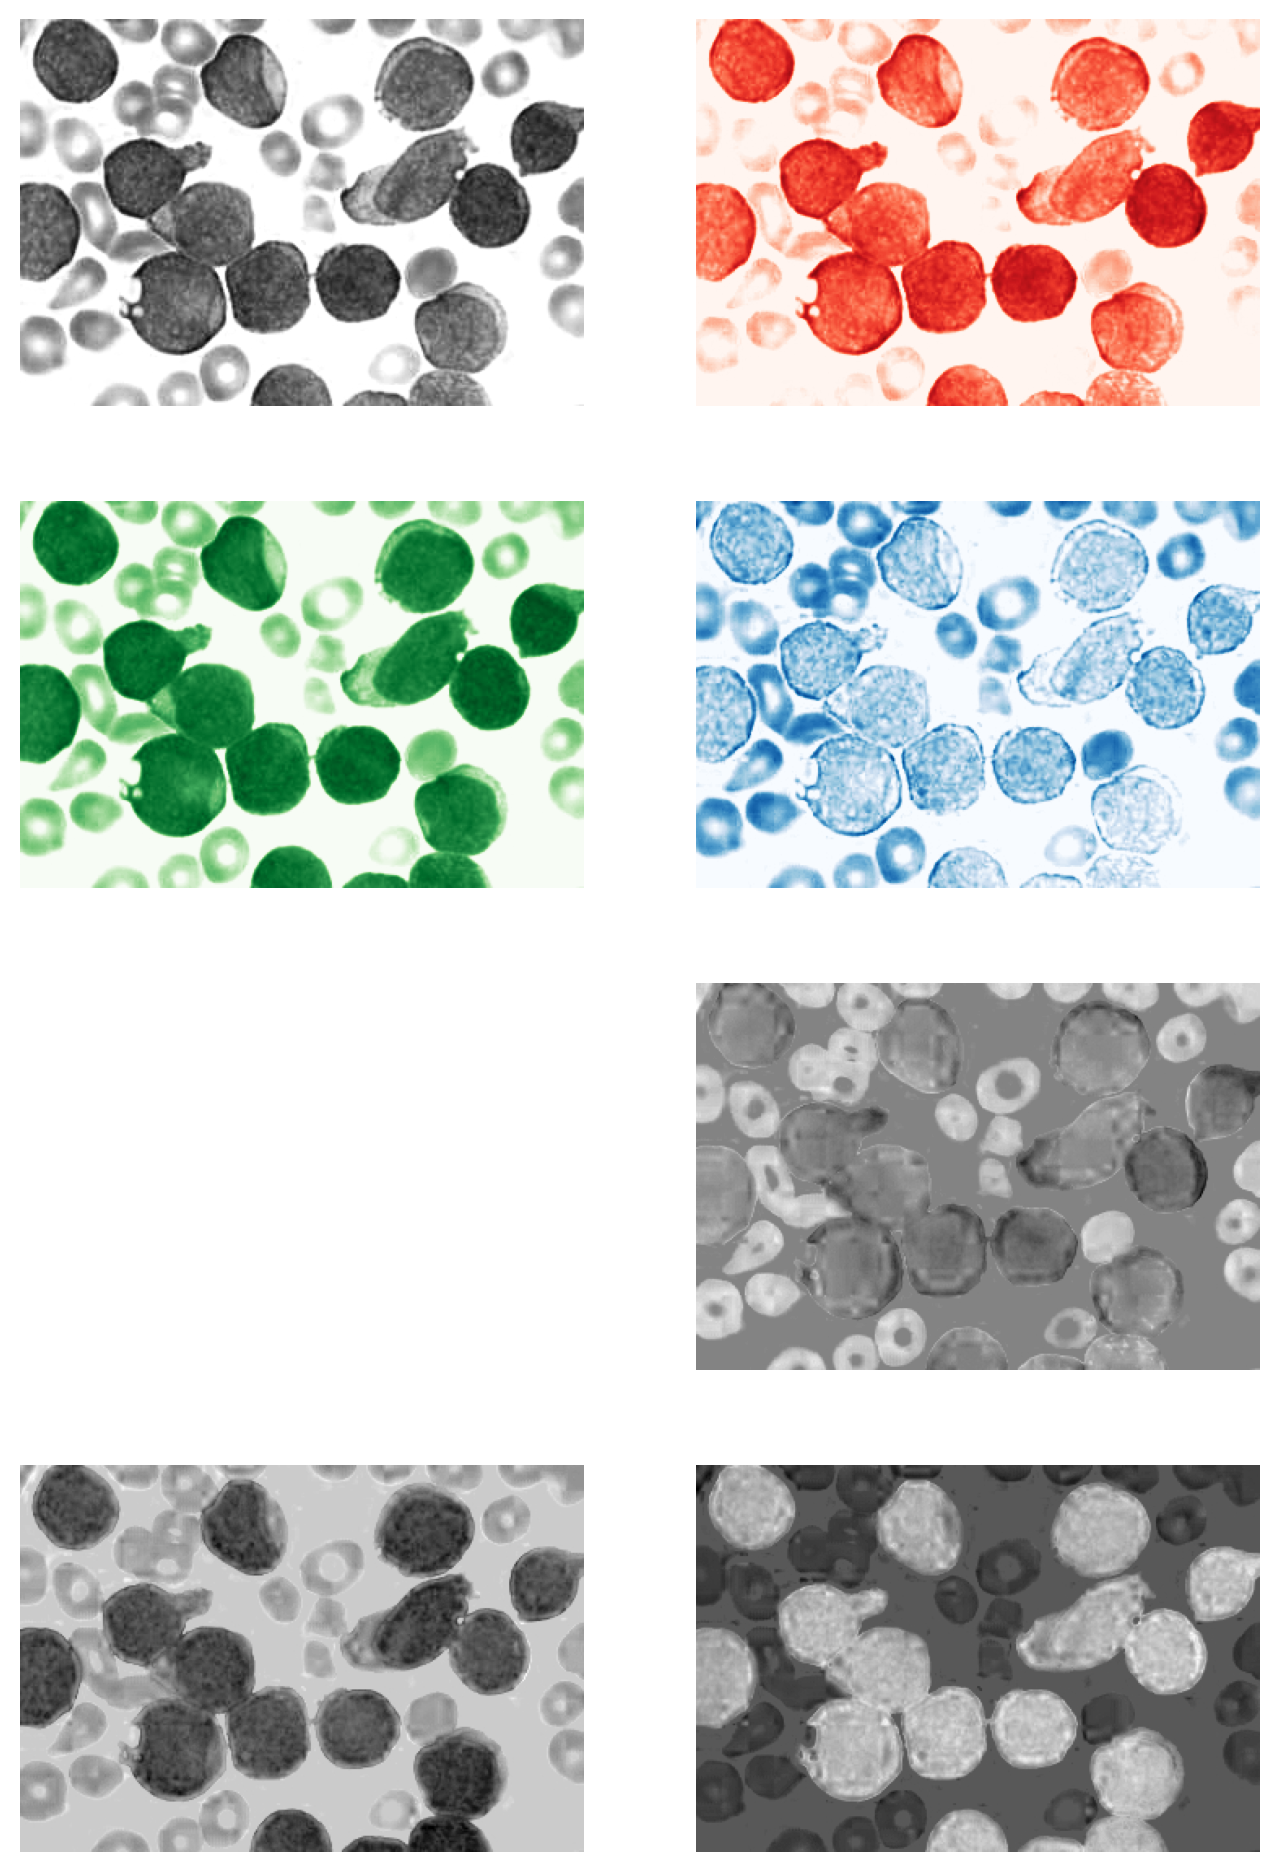

In [97]:
# Try your color maps here
fig , ax = plt.subplots(4,2,figsize = (8,12),sharex=True,sharey=True)
ax = ax.flatten()
for a in ax:
    a.axis('off')
ax[0].imshow(cells_gray,cmap='grey')
ax[1].imshow(cells[:,:,0],cmap='Reds_r')
ax[2].imshow(cells[:,:,1],cmap='Greens_r')
ax[3].imshow(cells[:,:,2],cmap='Blues_r')

ax[5].imshow(cells[:,:,0]-cells_gray,cmap='grey')
ax[6].imshow(cells[:,:,1]-cells_gray,cmap='grey')
ax[7].imshow(cells[:,:,2]-cells_gray,cmap='grey')

plt.show()

## Filtering images to smooth them
In our signal processing tutorial, we talked about convolving a signal with an averaging kernel to smooth the signal. We can apply similar logic to images. Let's start with a very simple image.

In [98]:
bright_square = np.zeros((7, 7), dtype=float)
bright_square[2:5, 2:5] = 1
bright_square

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

This gives the values above, and looks like this!

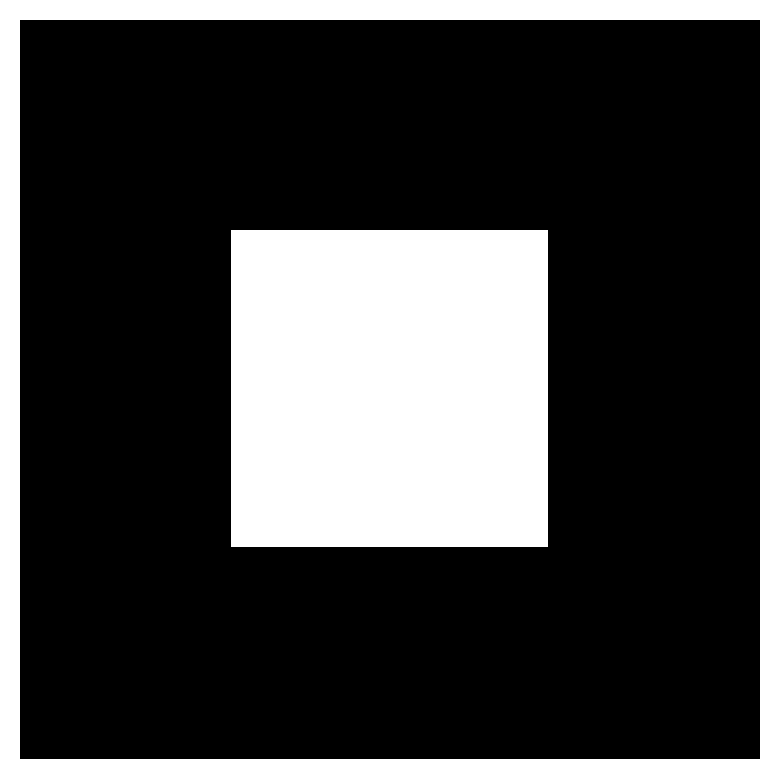

In [99]:
plt.imshow(bright_square,cmap='grey')
plt.axis('off')
plt.show()

For our first example of a filter, consider the following filtering array, which we’ll call a “mean kernel”. For each pixel, a kernel defines which neighboring pixels to consider when filtering, and how much to weight those pixels.

In [81]:
mean_kernel = np.full((3, 3), 1/9)

print(mean_kernel)

[[0.11 0.11 0.11]
 [0.11 0.11 0.11]
 [0.11 0.11 0.11]]


Now, let’s take our mean kernel and apply it to every pixel of the image.

Applying a (linear) filter essentially means:

1. Center a kernel on a pixel

2. Multiply the pixels under that kernel by the values in the kernel

3. Sum all the those results

4. Replace the center pixel with the summed result

This process is known as **convolution** (the same process we applied to a signal, but now in 3D!)

In [100]:
# Import image processing toolbox
import scipy.ndimage as ndi

# Set precision
%precision 2

print(ndi.correlate(bright_square, mean_kernel))

[[0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.33 0.67 1.   0.67 0.33 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]


Below we'll show a short demo of what this looks like. If you're curious how this runs, you can dig into the `convolution_demo.py` file.

In [101]:
%run convolution_demo.py
mean_filter_interactive_demo(bright_square);

interactive(children=(IntSlider(value=0, description='i_step', max=48), Output()), _dom_classes=('widget-inter…

This kind of mean filter is a bit brute. Typically, we'd use a Gaussian filter, where the amount of filtering depends on the distance from the center point. Thankfully, we can do that using the filters module:

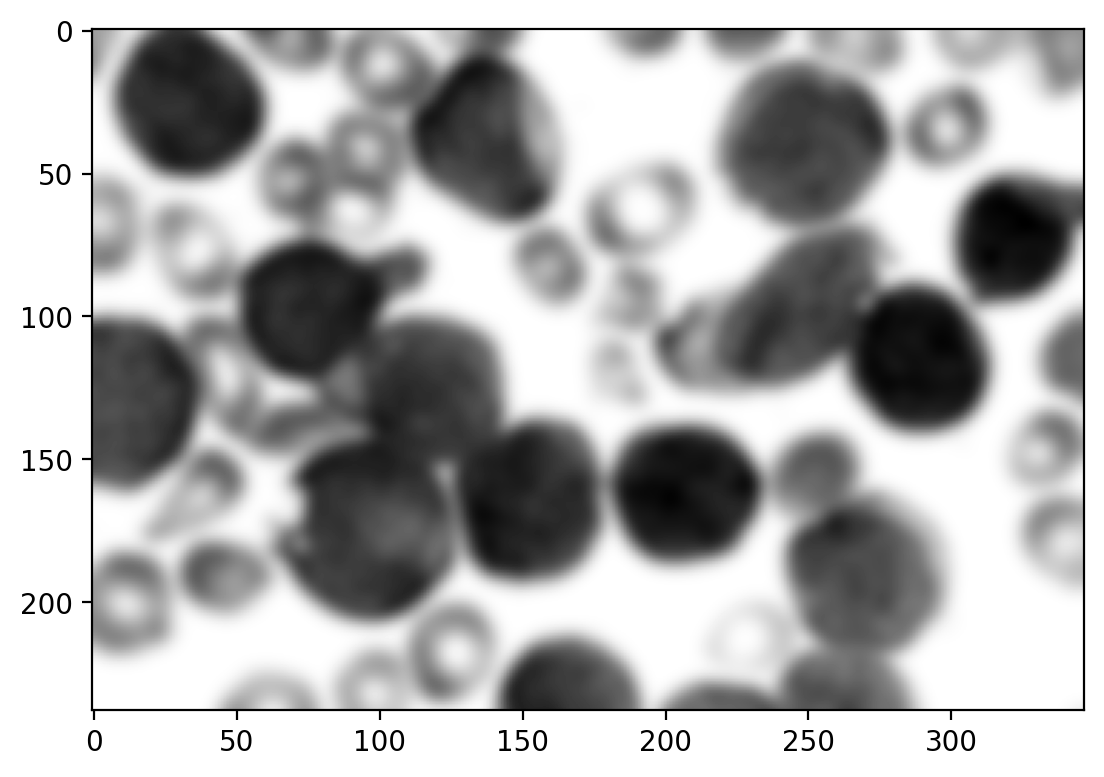

In [76]:
from skimage import filters

gaussian_cells = filters.gaussian(cells_gray,3)

plt.imshow(gaussian_cells,cmap='grey')
plt.show()

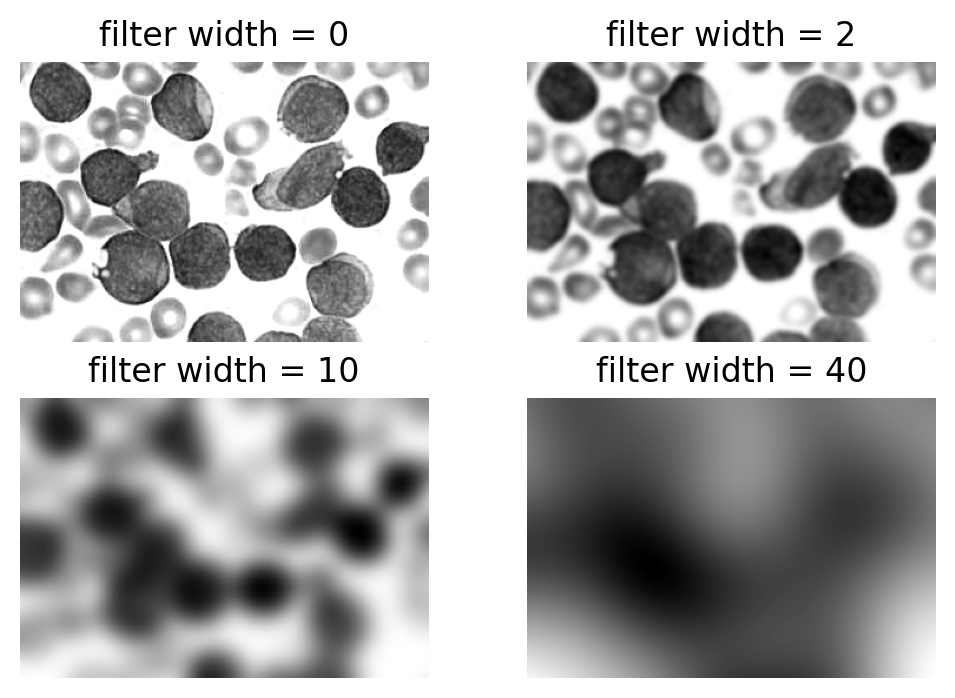

In [77]:
filt_widths = [0,2,10,40]

fig , ax = plt.subplots(2,2,figsize = (6,4))
ax = ax.flatten()

for i,a in enumerate(ax):
    a.axis('off')
    a.imshow(filters.gaussian(cells_gray,filt_widths[i]),cmap='grey')
    a.set_title('filter width = ' + str(filt_widths[i]))

## Edge filtering
In biology, we often want to filter edges to identify different features within cells, or cells within a piece of tissue. To do so, we'll often use some sort of edge filtering. To give you an intuition for how edge filtering works, first consider taking our step function and convolving it with a filter that is [-1 0 1].

**Note**: For technical signal processing reasons, convolutions actually occur “back to front” between the input array and the kernel. Correlations occur in the signal order, so we’ll use correlate from now on.

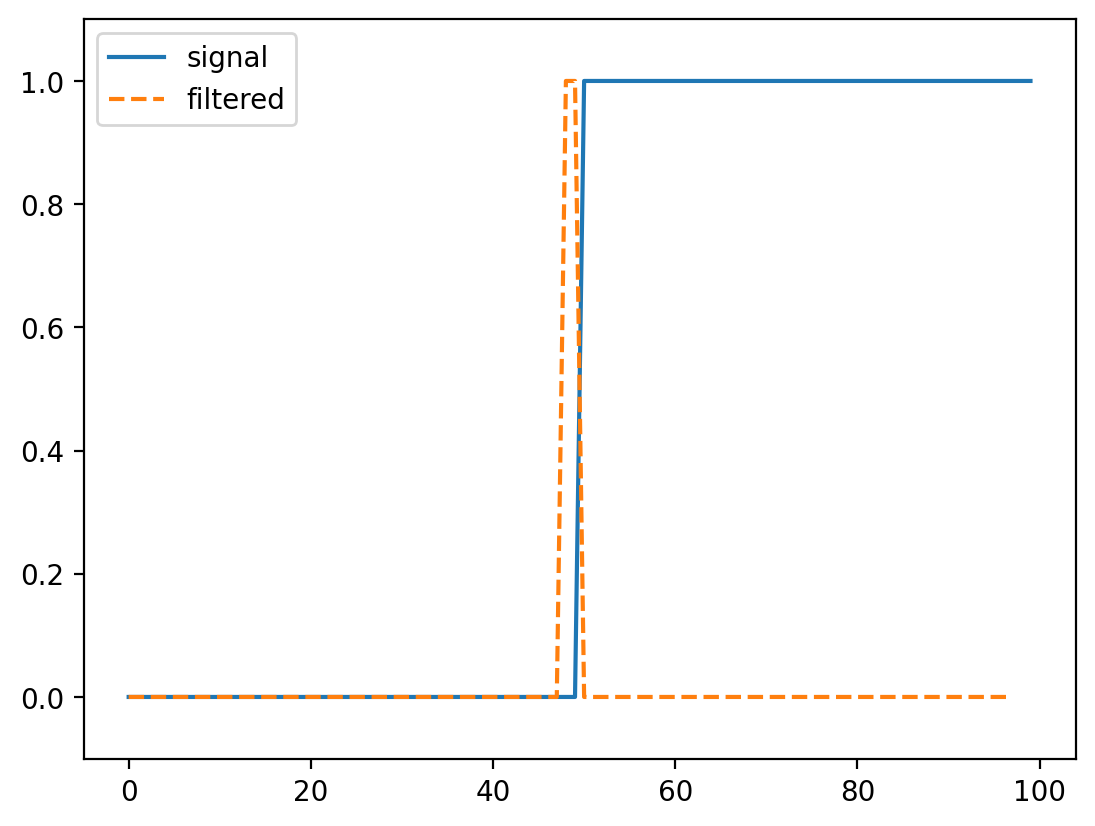

In [102]:
# Recreate the step signal
step_signal = np.zeros(100)
step_signal[50:] = 1

# Convolve it with a [-1 0 1] filter
edge_filter = np.correlate(step_signal, np.array([-1, 0, 1]),
                          mode='valid')

fig, ax = plt.subplots()
ax.plot(step_signal, label='signal')
ax.plot(edge_filter, linestyle='dashed', label='filtered')
ax.legend(loc='upper left')
ax.margins(y=0.1) 

Whenever neighboring values are close, the filter response is close to 0. Right at the boundary of a step, we’re subtracting a small value from a large value and and get a spike in the response. This spike “identifies” our edge.

Now, let's apply this to images. Below, we'll just apply one filter, in the vertical direction.

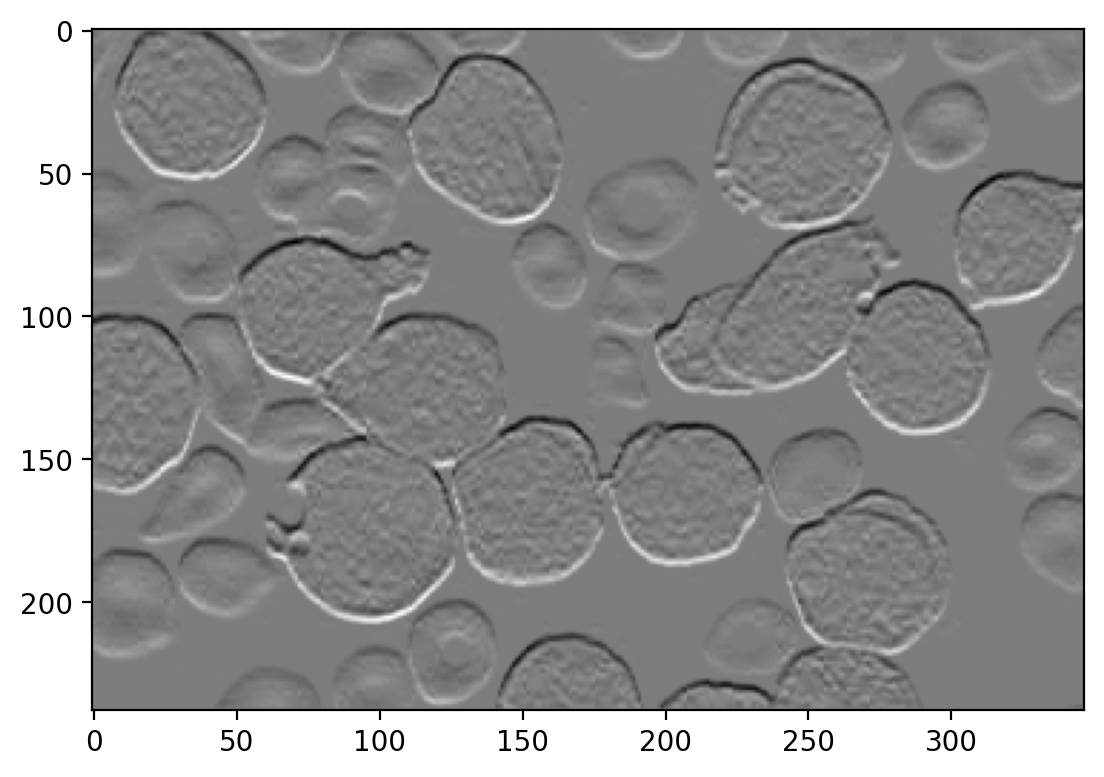

In [68]:
vertical_kernel = np.array([
    [-1],
    [ 0],
    [ 1],
])

gradient_vertical = ndi.correlate(cells_gray.astype(float),vertical_kernel)
plt.imshow(gradient_vertical,cmap='gray')
plt.show()

As you can see, applying a filter in the vertical direction helps us identify horizontal edges.
<div class="alert alert-success">

**Task**: Change the filter to a horizontal one and observe how this changes the edge detection.
</div>

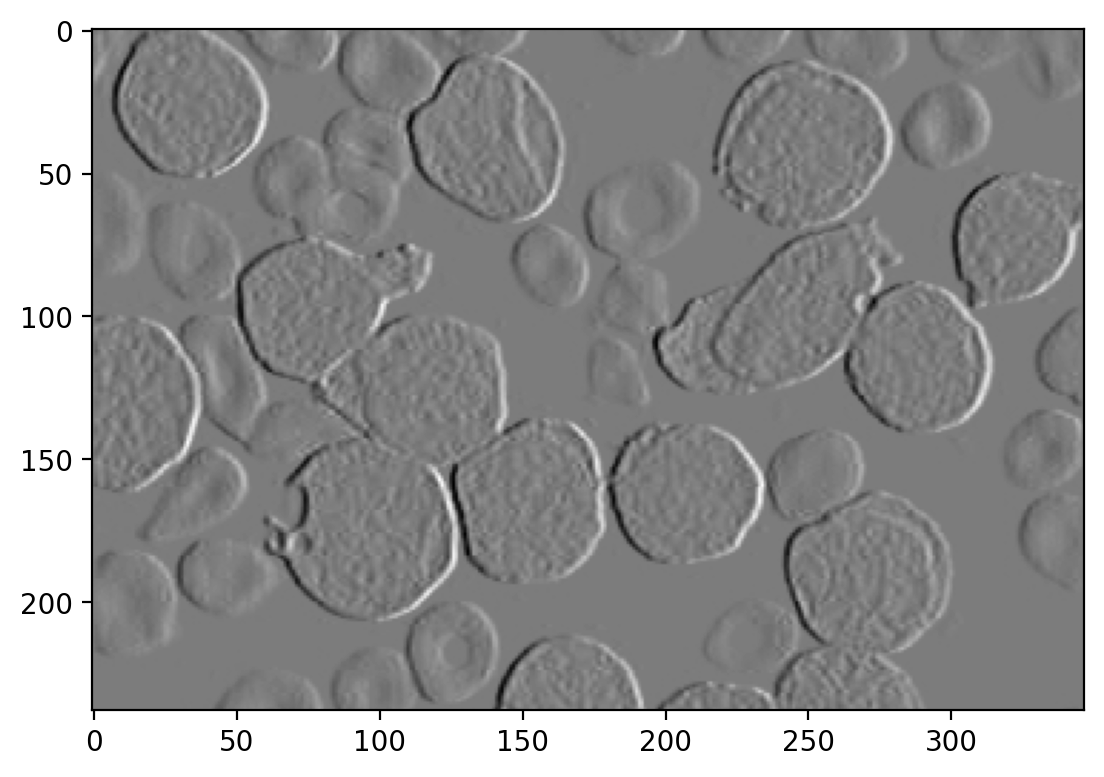

In [73]:
horizontal_kernel = np.array([[-1,0,1]])

gradient_horizontal = ndi.correlate(cells_gray.astype(float),horizontal_kernel)
plt.imshow(gradient_horizontal,cmap='gray')
plt.show()

Thankfully, there's a commonly used filter, the **Sobel** edge filter, that does this for us. First, let's appreciate what it looks like for our bright square.

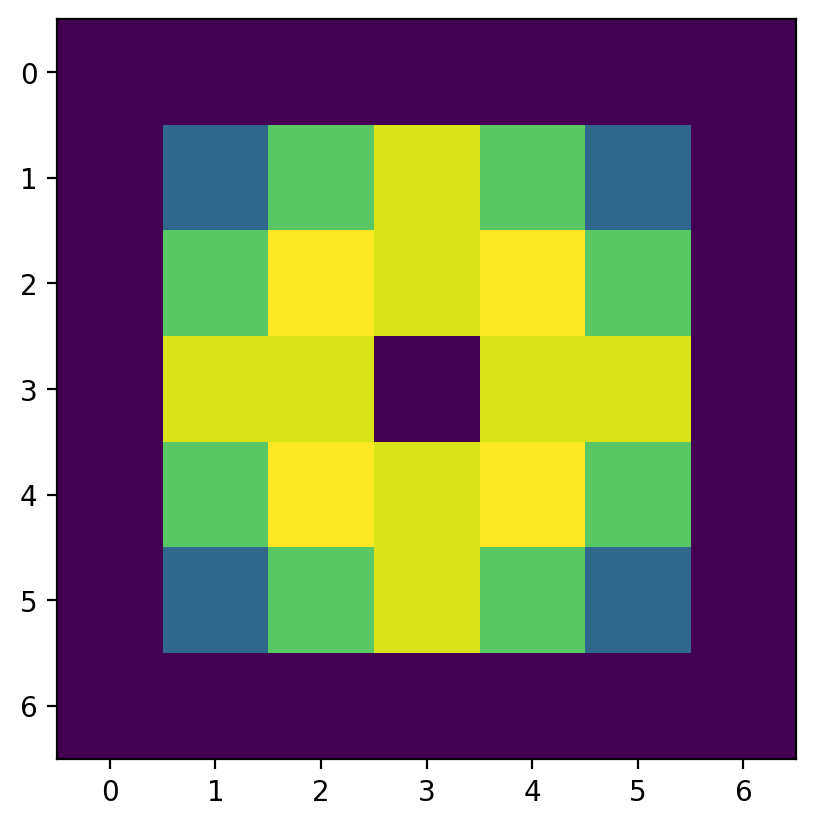

In [74]:
plt.imshow(filters.sobel(bright_square))
plt.show()

Now, let's apply it to our cells! 
<div class="alert alert-success">
    
**Task**: Create a figure where the left subplot is a filter of our raw cell image. On the right, apply it to the Gaussian filtered image.
    
</div>

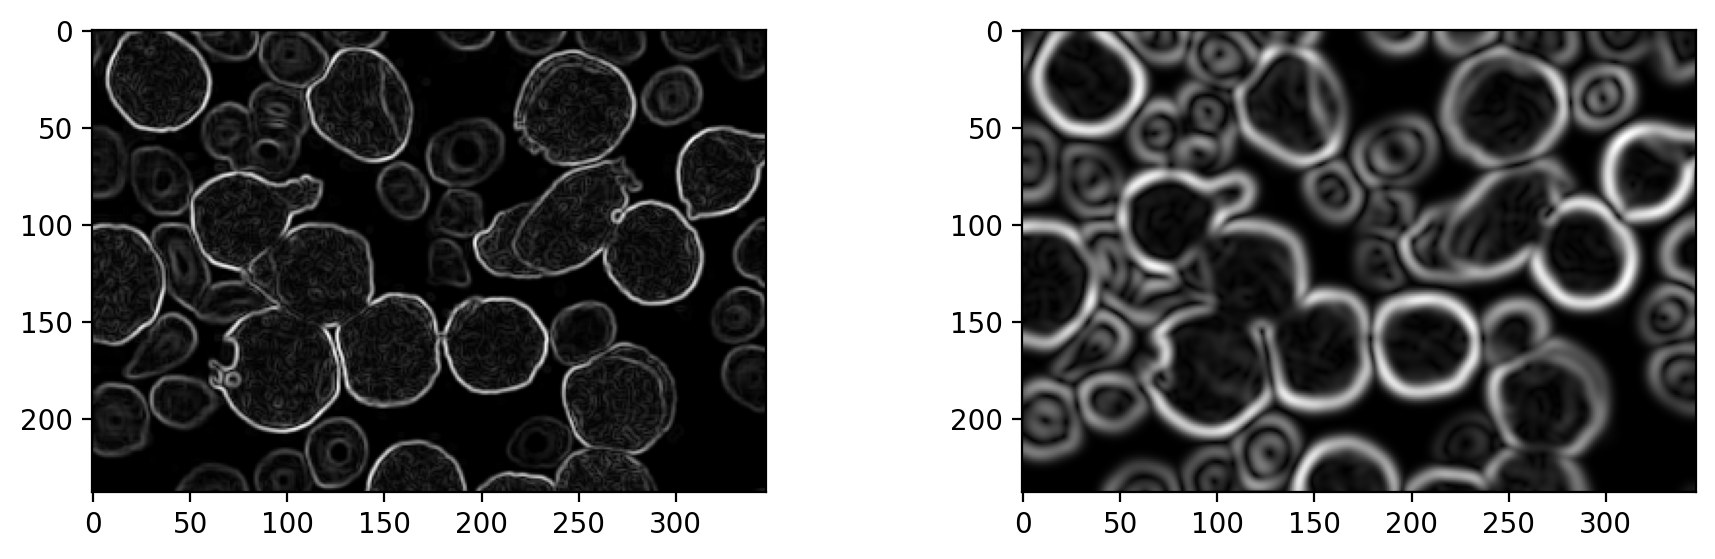

In [75]:
fig,ax = plt.subplots(1,2,figsize=(11,3))

ax[0].imshow(filters.sobel(cells_gray),cmap='gray')
ax[1].imshow(filters.sobel(gaussian_cells),cmap='gray')

plt.show()

Note that even just a little bit of preprocessing with a Gaussian filter changes the edge detection!

## About this notebook
* Several of the exercises in this notebook are based on [this tutorial](https://jni.github.io/i2k-skimage-napari/lectures/1_image_filters.html#local-filtering).

* https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/
* https://jni.github.io/i2k-skimage-napari/lectures/1_image_filters.html#local-filtering